Importing Libraries

In [188]:
import numpy as np
import pandas as pd
from utils import *
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
from utils import calculate_aic_bic, calculate_adjusted_r2, calculate_aic_bic
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
'''
Load the data and split it into train and test
'''
data = pd.read_csv('Data/data_with_lags_and_powers_feature_selected.csv', index_col = 0, parse_dates=True)
data.head()

test_data = data.iloc[-int(len(data) * 0.1):]
train_data = data.iloc[:-int(len(data) * 0.1)]

test_X = test_data.iloc[:,1:]
test_y = test_data.iloc[:,0:1]

train_X = train_data.iloc[:,1:]
train_y = train_data.iloc[:,0:1]

1 - Linear Regression

In [194]:
'''
Run the linear regression model
First we fit the model on the train data and then predict the test data
'''
def evaluate_linear_regression(X_train, y_train, X_val, y_val):
    # Initialize the model
    model = LinearRegression()
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns)
    y = pd.DataFrame(scaler_y.fit_transform(y_train .values.reshape(-1, 1)), columns=['Realized Volatility'])

    # Fit the model
    model.fit(X, y)
    
    print('Model coefficients are: \n',model.coef_)
    
    X_val = scaler_X.transform(X_val)
    # Predict the validation set results
    y_pred = model.predict(X_val)
    
    y_pred = scaler_y.inverse_transform(y_pred)
    y_pred = pd.DataFrame(y_pred, columns=['Realized Volatility'], index = y_val.index)
    # Calculate the metrics
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mape = mean_absolute_percentage_error(y_val, y_pred)
    cp = calculate_cp(y_val.values, y_pred.values, train_X.shape[1], train_X.shape[0])
    adjusted_r2 = calculate_adjusted_r2(y_val.values, y_pred.values, train_X.shape[1], train_X.shape[0])
    aic, bic = calculate_aic_bic(y_val.values, y_pred.values, train_X.shape[1], train_X.shape[0])

    print(f"The scores on the test set are: \n MSE: {mse} \n, RMSE: {rmse}\n, MAE: {mae}\n, R^2: {r2}\n, Adjusted R^2: {adjusted_r2}\n, C_p: {cp}\n, AIC: {aic}\n, BIC: {bic}\n, MAPE: {mape}\n")

    return y_pred


y_pred = evaluate_linear_regression(train_X, train_y, test_X, test_y)

Model coefficients are: 
 [[ 0.47186998  0.01132719  0.02465749 -0.01374927  0.00099447  0.00328454
   0.01559837  0.03754595  0.07950872 -0.0276414  -0.08094555  0.07832266
   0.06566807 -0.48612037 -0.03300253 -0.07288252  0.54532955 -0.00398018
   0.01191754 -0.0296449   0.02107653 -0.28799719  0.08117805]]
The scores on the test set are: 
 MSE: 5.4362203890565935e-06 
, RMSE: 0.0023315703697415167
, MAE: 0.0017439076597294337
, R^2: -0.12516775687914983
, Adjusted R^2: -0.14080452933124676
, C_p: 6.189643252662838e-07
, AIC: -597.1646972721985
, BIC: -23876.90471802303
, MAPE: 0.28254029038900896



In [195]:
y_pred.rename(columns = {'Realized Volatility': 'Predicted Volatility'}, inplace = True)
results_regression = pd.concat([test_y, y_pred], axis = 1)
results_regression.head()

,Realized Volatility,Predicted Volatility
2023-04-05,0.005790,0.006934
2023-04-06,0.005496,0.006939
2023-04-10,0.008563,0.006473
2023-04-11,0.003862,0.007150
2023-04-12,0.009014,0.005194


<Axes: >

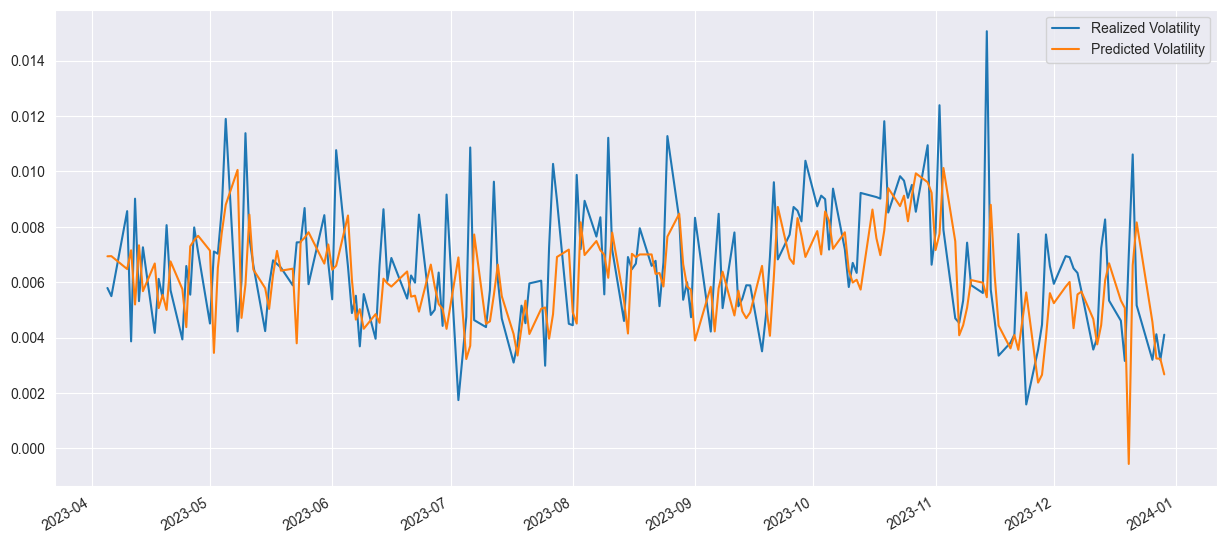

In [196]:
results_regression.plot(figsize = (15, 7))

In [197]:
results_regression.to_csv('Outputs/Models/Linear Regression/linear_regression_results.csv')

2 - Lasso Regression

In [198]:
'''
Load the data and split it into train and test
'''
data = pd.read_csv('Data/raw_data_stationary_abs_return_with_two_lags_and_powers.csv', index_col = 0, parse_dates=True)
data.head()

test_data = data.iloc[-int(len(data) * 0.1):]
train_data = data.iloc[:-int(len(data) * 0.1)]

test_X = test_data.iloc[:,1:]
test_y = test_data.iloc[:,0:1]

train_X = train_data.iloc[:,1:]
train_y = train_data.iloc[:,0:1]

In [199]:
'''
Function for finding the best model with Lasso or Ridge regression using times series cross validation
'''

def evaluate_regularized_regression_ts_cv(X, y, hyperparameters, model_type="Lasso", n_splits=5):
    best_score = np.inf
    best_pred = None
    best_model = None

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns)
    y_scaled = pd.DataFrame(scaler_y.fit_transform(y.values.reshape(-1, 1)), columns=['Realized Volatility'])

    tscv = TimeSeriesSplit(n_splits=n_splits)

    for alpha in hyperparameters['alpha']:
        cv_scores = []
        for train_index, val_index in tscv.split(X_scaled):
            X_train, X_val = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
            y_train, y_val = y_scaled.iloc[train_index], y_scaled.iloc[val_index]

            if model_type == "Lasso":
                model = Lasso(alpha=alpha, max_iter=10000, fit_intercept=True)
            elif model_type == "Ridge":
                model = Ridge(alpha=alpha, max_iter=10000, fit_intercept=True)

            # Fit the model
            model.fit(X_train, y_train)

            # Predict the validation set results
            y_pred = model.predict(X_val)
            y_pred = y_pred.reshape(-1, 1)
            y_pred = scaler_y.inverse_transform(y_pred)
            y_pred = pd.DataFrame(y_pred, columns=['Realized Volatility'], index=y_val.index)

            # Calculate the metrics
            MAPE = mean_absolute_percentage_error(scaler_y.inverse_transform(y_val), y_pred)
            cv_scores.append(MAPE)

        mean_cv_score = np.mean(cv_scores)
        if mean_cv_score < best_score:
            best_score = mean_cv_score
            best_model = model

        print(f"Results for alpha = {alpha}: MAPE = {mean_cv_score}")

    print(f"Best alpha for MAPE: {best_model.alpha} which gives MAPE: {best_score}")
    return best_model


In [200]:
'''
Function for finding the scores of a specific model with Lasso or Ridge regression
'''
def evaluate_regularized_regression(X_train, y_train, X_val, y_val, alpha,  model_type = "Lasso"):
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns)
    y = pd.DataFrame(scaler_y.fit_transform(y_train .values.reshape(-1, 1)), columns=['Realized Volatility'])
    
    X_val = scaler_X.transform(X_val)
    
    if model_type == "Lasso":
        model = Lasso(alpha=alpha, max_iter=10000, fit_intercept=True)
    elif model_type == "Ridge":
        model = Ridge(alpha=alpha, max_iter=10000, fit_intercept=True)
        
        # Fit the model
    model.fit(X, y)

    # Predict the validation set results
    y_pred = model.predict(X_val)
    y_pred = y_pred.reshape(-1, 1)
    y_pred = scaler_y.inverse_transform(y_pred)
    y_pred = pd.DataFrame(y_pred, columns=['Realized Volatility'], index = y_val.index)
    
    # Calculate the metrics
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    MAPE = mean_absolute_percentage_error(y_val, y_pred)
    cp = calculate_cp(y_val.values, y_pred.values, X_train.shape[1], X_train.shape[0])
    adjusted_r2 = calculate_adjusted_r2(y_val.values, y_pred.values, X_train.shape[1], X_train.shape[0])
    aic, bic = calculate_aic_bic(y_val.values, y_pred.values, X_train.shape[1], X_train.shape[0])
    

    print(f"Results for alpha = {alpha}: \n MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R^2: {r2}, Adjusted R^2: {adjusted_r2}, C_p: {cp}, AIC: {aic}, BIC: {bic}, MAPE: {MAPE}")

    return y_pred, model


In [201]:
'''
Finding the best hyperparameter for the Lasso regression model
'''
hyperparameters = {'alpha': [0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
best_model = evaluate_regularized_regression_ts_cv(train_X, train_y, hyperparameters, model_type = "Lasso", n_splits=5)

Results for alpha = 1e-05: MAPE = 0.3176694628032409
Results for alpha = 0.0001: MAPE = 0.3152557786856695
Results for alpha = 0.001: MAPE = 0.3773193750572764
Results for alpha = 0.01: MAPE = 0.5068812166725178
Results for alpha = 0.1: MAPE = 0.5068812166725178
Results for alpha = 1: MAPE = 0.5068812166725178
Results for alpha = 10: MAPE = 0.5068812166725178
Results for alpha = 100: MAPE = 0.5068812166725178
Results for alpha = 1000: MAPE = 0.5068812166725178
Best alpha for MAPE: 0.0001 which gives MAPE: 0.3152557786856695


In [202]:
y_pred, model = evaluate_regularized_regression(train_X, train_y, test_X, test_y, alpha = best_model.alpha, model_type = "Lasso")

Results for alpha = 0.0001: 
 MSE: 5.039814222906748e-06, RMSE: 0.002244953055835856, MAE: 0.0016154595314616627, R^2: -0.04312115007164152, Adjusted R^2: -0.06211000595886795, C_p: 5.786386447256801e-07, AIC: -597.2476532532504, BIC: -23952.048220338467, MAPE: 0.25697093438847285


In [203]:
'''
Printing the coefficients of the best model to see which columns are selected by Lasso
'''
for coeff in zip(train_X.columns, model.coef_):
    print("Feature: {}, Coefficient: {}".format(coeff[0], coeff[1]))

Feature: Realized Volatility_lag_1, Coefficient: 0.2177515152047829
Feature: Realized Volatility_lag_2, Coefficient: 0.21889812055912797
Feature: ADS_lag_1, Coefficient: -0.009657195717991052
Feature: ADS_lag_2, Coefficient: -0.0
Feature: US Policy Index_lag_1, Coefficient: -0.027890504735732336
Feature: US Policy Index_lag_2, Coefficient: -0.0036049709634660074
Feature: VIX_lag_1, Coefficient: 0.23695243314874778
Feature: VIX_lag_2, Coefficient: 0.008302617728099189
Feature: Volume_lag_1, Coefficient: 0.0
Feature: Volume_lag_2, Coefficient: 0.0
Feature: Sentiment Score_lag_1, Coefficient: -0.0036746836123103116
Feature: Sentiment Score_lag_2, Coefficient: -0.0
Feature: Dollar_index_ret_lag_1, Coefficient: -0.0
Feature: Dollar_index_ret_lag_2, Coefficient: 0.003502398479381606
Feature: term_spread_ret_lag_1, Coefficient: 0.0
Feature: term_spread_ret_lag_2, Coefficient: 0.009393689279667859
Feature: 13w TB_ret_lag_1, Coefficient: 0.0
Feature: 13w TB_ret_lag_2, Coefficient: -0.0
Feature:

In [204]:
y_pred.rename(columns = {'Realized Volatility': 'Predicted Volatility'}, inplace = True)
results_lasso = pd.concat([test_y, y_pred], axis = 1)
results_lasso.head()

,Realized Volatility,Predicted Volatility
2023-04-05,0.005790,0.006665
2023-04-06,0.005496,0.006861
2023-04-10,0.008563,0.006809
2023-04-11,0.003862,0.006904
2023-04-12,0.009014,0.006594


<Axes: >

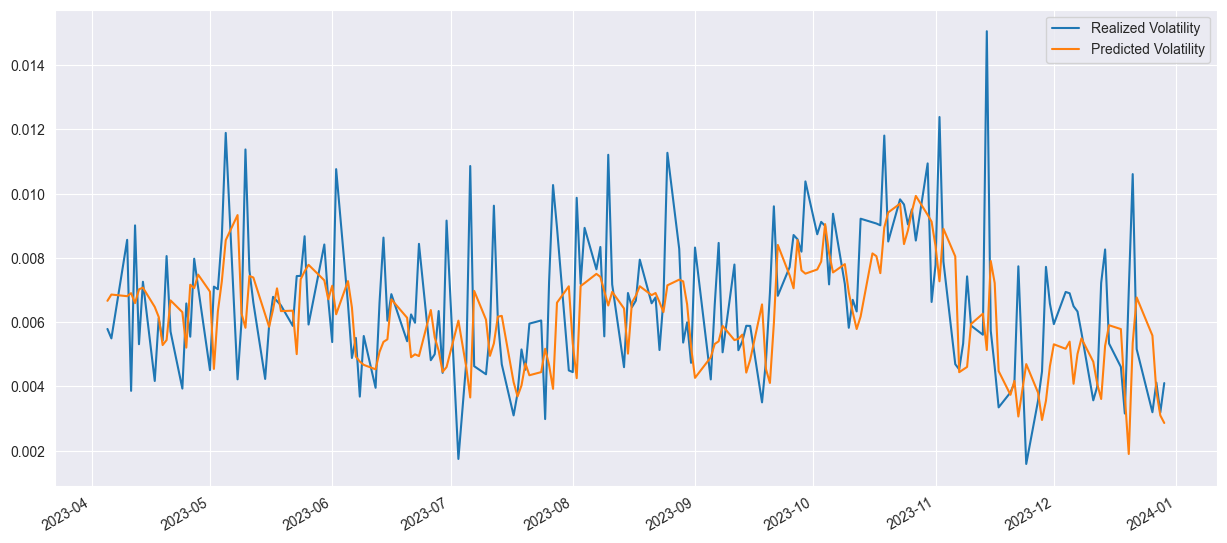

In [205]:
results_lasso.plot(figsize = (15, 7))

In [206]:
results_lasso.to_csv('Outputs/Models/Lasso/Lasso_results.csv')

3 - Ridge Regression

In [207]:
hyperparameters = {'alpha': [0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
best_model = evaluate_regularized_regression_ts_cv(train_X, train_y, hyperparameters, model_type = "Ridge", n_splits=5)

Results for alpha = 1e-05: MAPE = 0.6406098706251784
Results for alpha = 0.0001: MAPE = 0.39614857426204264
Results for alpha = 0.001: MAPE = 0.34847581005261447
Results for alpha = 0.01: MAPE = 0.34226500828770867
Results for alpha = 0.1: MAPE = 0.32110172560328076
Results for alpha = 1: MAPE = 0.3211223418461202
Results for alpha = 10: MAPE = 0.36976891575585136
Results for alpha = 100: MAPE = 0.45342448780573286
Results for alpha = 1000: MAPE = 0.49717220573866633
Best alpha for MAPE: 0.1 which gives MAPE: 0.32110172560328076


In [208]:
for coeff in zip(train_X.columns, best_model.coef_[0]):
    print("Feature: {}, Coefficient: {}".format(coeff[0], coeff[1]))

Feature: Realized Volatility_lag_1, Coefficient: 0.2697566865574114
Feature: Realized Volatility_lag_2, Coefficient: 0.18852900446432994
Feature: ADS_lag_1, Coefficient: -0.12618853105927427
Feature: ADS_lag_2, Coefficient: 0.05693691223844396
Feature: US Policy Index_lag_1, Coefficient: -0.002444040844863716
Feature: US Policy Index_lag_2, Coefficient: -0.0031930048117151935
Feature: VIX_lag_1, Coefficient: 0.13489852559223245
Feature: VIX_lag_2, Coefficient: 0.06884992799773906
Feature: Volume_lag_1, Coefficient: -0.009009593242483401
Feature: Volume_lag_2, Coefficient: -0.0061716968238011176
Feature: Sentiment Score_lag_1, Coefficient: -0.007282060959964031
Feature: Sentiment Score_lag_2, Coefficient: -0.006046170473197107
Feature: Dollar_index_ret_lag_1, Coefficient: -0.005139265817535506
Feature: Dollar_index_ret_lag_2, Coefficient: 0.0212604585507945
Feature: term_spread_ret_lag_1, Coefficient: 0.041041760435532953
Feature: term_spread_ret_lag_2, Coefficient: 0.0636878076630191
F

In [209]:
y_pred, model = evaluate_regularized_regression(train_X, train_y, test_X, test_y,alpha=best_model.alpha, model_type = "Ridge")


Results for alpha = 0.1: 
 MSE: 5.28763360421925e-06, RMSE: 0.002299485508590835, MAE: 0.0016422708899949917, R^2: -0.09441384194702684, Adjusted R^2: -0.1143364240213054, C_p: 6.07091652038461e-07, AIC: -588.3193573047295, BIC: -23871.453548846177, MAPE: 0.25883780478125584


In [210]:
y_pred.rename(columns = {'Realized Volatility': 'Predicted Volatility'}, inplace = True)
results_ridge = pd.concat([test_y, y_pred], axis = 1)
results_ridge.head()

,Realized Volatility,Predicted Volatility
2023-04-05,0.005790,0.006923
2023-04-06,0.005496,0.007094
2023-04-10,0.008563,0.006857
2023-04-11,0.003862,0.006645
2023-04-12,0.009014,0.006569


<Axes: >

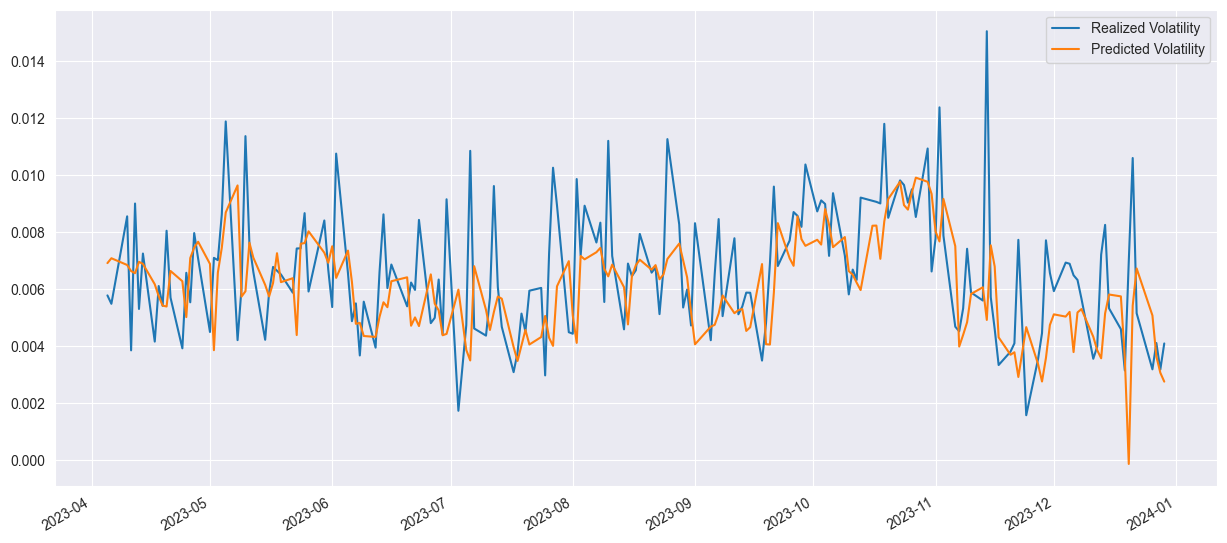

In [211]:
results_ridge.plot(figsize = (15, 7))

In [212]:
results_ridge.to_csv('Outputs/Models/Ridge/Ridge_results.csv')